In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append('../DSTM')

In [3]:
from dstm.util.sampling.ic_curve import ICCurveBeamSearch

In [4]:
import torch
import os
from CIA.getters import get_handler, get_data_processor, \
    get_dataloader_generator, get_decoder, get_positional_embedding,\
    get_sos_embedding
# from CIA.handlers.decoder_events_handler import 
import time
import importlib
from CIA.positional_embeddings.positional_embedding import PositionalEmbedding
from torch.nn.parallel import DistributedDataParallel
import einops
from CIA.utils import get_free_port
from CIA.data_processors.data_processor import DataProcessor
from CIA.handlers.decoder_events_handler import DecoderEventsHandler
import numpy as np
import matplotlib.pyplot as plt
import functools
from pathlib import Path
import miditoolkit
import pretty_midi

In [5]:
GPU = 0
rank = GPU
world_size = 1
rank = 0
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = str(get_free_port())
if torch.cuda.is_available() and GPU in list(range(4)):
    torch.distributed.init_process_group(backend="nccl", world_size=world_size, rank=rank)
    torch.cuda.set_device(rank)
    device_ids = [rank]
    output_device = rank
    device = f"cuda:{rank}"
else:
    # cpu case
    torch.distributed.init_process_group(backend="gloo", world_size=world_size, rank=rank)
    device_ids = None
    output_device = None
    device = "cpu"


In [6]:
model_dir = 'models/piano_event_performer_2021-10-01_16:03:06'
# config =  importlib.import_module('CIA.configs.piarceiverStack').config
# NOTE: override configuration
config = importlib.import_module('.config_autoreg', f'{model_dir.replace("/", ".")}').config
for t in ['time_dilation', 'velocity_shift', 'transposition']:
    config['dataloader_generator_kwargs']['transformations'][t] = False
config['data_processor_kwargs']['num_events_before'] = 1
config['data_processor_kwargs']['num_events_after'] = 0
# TODO: check correct number...
num_events_middle = 1024 - 6
num_max_generated_events = 1024 - 6

load = True
overfitted = True

# === Decoder ====
# dataloader generator
dataloader_generator = get_dataloader_generator(
    dataset=config["dataset"],
    dataloader_generator_kwargs=config["dataloader_generator_kwargs"],
)

# data processor
data_processor: DataProcessor = get_data_processor(
    dataloader_generator=dataloader_generator,
    data_processor_type=config["data_processor_type"],
    data_processor_kwargs=config["data_processor_kwargs"],
)

# positional embedding
positional_embedding: PositionalEmbedding = get_positional_embedding(
    dataloader_generator=dataloader_generator,
    positional_embedding_dict=config["positional_embedding_dict"],
)

# sos embedding
sos_embedding = get_sos_embedding(
    dataloader_generator=dataloader_generator,
    sos_embedding_dict=config["sos_embedding_dict"],
)

decoder = get_decoder(
    data_processor=data_processor,
    dataloader_generator=dataloader_generator,
    positional_embedding=positional_embedding,
    sos_embedding=sos_embedding,
    decoder_kwargs=config["decoder_kwargs"],
    training_phase=False,
    handler_type=config["handler_type"],
)

decoder.to(device)
decoder = DistributedDataParallel(
    module=decoder,
    device_ids=[rank] if GPU is not None else None,
    output_device=rank
    # )
    ,
    find_unused_parameters=True,
)

decoder_handler = get_handler(
    handler_type=config["handler_type"],
    decoder=decoder,
    model_dir=model_dir,
    dataloader_generator=dataloader_generator,
)

if load:
    if overfitted:
        decoder_handler.load(early_stopped=False)
    else:
        decoder_handler.load(early_stopped=True)

if hasattr(decoder_handler.model.module.transformer, "fix_projection_matrices_"):
    decoder_handler.model.module.transformer.fix_projection_matrices_()



Loading index dictionnary
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will

In [7]:
# Load a piece (for inpainting)
# null_superconditioning = [1, 1.5, 2, 2.5]


# (_, generator_val, _) = dataloader_generator.dataloaders(
#     batch_size=1, num_workers=num_workers, shuffle_val=True
# )
# original_x = next(generator_val)["x"]
piece = 'Bach, Carl Philipp Emanuel, Keyboard Sonata in F major, H.55, zRPTf8eGLWc'
# {-63, -53, ..., -3, 7, ... }
start_time = -3
for split, samples in  dataloader_generator.dataset.list_ids.items():
    for id_, sample in enumerate(samples):
        if piece == sample['score_name'] and start_time == sample['start_time']:
            break
    else:
        continue
    break
dataloader_generator.dataset.split = split
data = dataloader_generator.dataset[id_]
original_x = torch.stack([data[e] for e in dataloader_generator.features], dim=-1)[None]
# NOTE: num_events_middle likely the number of notes which will be created? Actually more events are created...
# NOTE: first event is always the same, probably because it's a special start token, .
# NOTE: Num events, most likely, defines the event (after decode start) that should be how long time (in the original score) we should we should generate. 
# TODO: what's the difference between num_events_middle and num_max_generated_events? Probably 
# Only needed for setting up start_decode and end_decode.
# Does the model actually actually not attend to the after (future) tokens while decoding? 
# Actually preprocess should return (shuffle the data): 
# before  middle  after -> before  placeholder  after  SOD (start of decoding)  middle  END XX XX (pad)
# NOTE: metadata_dict['decoding_end'] is not used for inpaint_non_optimized 

x, metadata_dict = data_processor.preprocess(original_x, num_events_middle=num_events_middle)

In [ ]:
# "open ended"
secs_dec = 25.
batch_size = 1
placeholder, placeholder_duration_token = data_processor.compute_placeholder(placeholder_duration=torch.tensor([secs_dec]), batch_size=batch_size)
before = einops.repeat(data_processor.start_tokens, 'd ->b 1 d', b=batch_size)
after = torch.empty(batch_size, 0, placeholder.shape[-1], dtype=torch.long, device=device)
sod =  einops.repeat(data_processor.start_tokens, 'd ->b 1 d', b=batch_size)
query = torch.cat([before, placeholder, after, sod], dim=1)
middle = torch.zeros(batch_size, num_events_middle-1, placeholder.shape[-1], dtype=torch.long, device=device)
end = einops.repeat(data_processor.end_tokens, 'd ->b 1 d', b=batch_size)
padding_len = config['dataloader_generator_kwargs']['sequences_size'] - query.shape[1] - middle.shape[1] - 1
padding = einops.repeat(data_processor.end_tokens, 'd ->b padding d', b=batch_size, padding=padding_len)
x = torch.cat([
    query,
    middle,
    end, 
    padding,

],
axis=1)
metadata_dict = {
    'placeholder_duration': torch.tensor([secs_dec], device=device),
    'decoding_start': query.shape[1],
    # 'decoding_end': query.shape[1] - 1+  num_events_middle,
}

In [7]:

# NOTE: with current setup this corresponds to open ended generation.
# [START]  placeholder (programs the model to decode until a certain total time, where the end note is produced)  []  SOD  [m0,m1,...,m9]  END XX XX
# NOTE: loss_mask is not used in inpainting, how do we handle attention mask?
# metadata_dict.pop('loss_mask')
# metadata_dict['decoding_start'] = 0
# metadata_dict['decoding_end'] = 1024
start_time = time.time()
# NOTE: Here it always attends (!autoregressively!) to full sequence but updates during (autoregressive) decoding.
# NOTE: model decodes from decode start and decode up to the next num_events_middle. 
# If at one time the placeholder_duration is exceeded, or END symbol, then it terminates with done.
# Otherwise it terminates after resampling all events in "middle".

# NOTE: When generating all channels of a note, the prob is not autoreg, instead the state of previous note is computed, 
# and the model is "programed" to generate a certain token in the head, by appending previous computed embeddings to he state
# 
#  If it did not . We can probably fix this 
# by giving a sequence of some mask token, from the beginning. 
(
    x_gen,
    generated_region,
    decoding_end,
    num_event_generated,
    done,
) = decoder_handler.inpaint_non_optimized(
    x=x.clone(), metadata_dict=metadata_dict, temperature=1.0, top_p=0.95, top_k=0, num_max_generated_events=num_max_generated_events
)
end_time = time.time()

# x_inpainted = torch.cat([before, generated_region, after, end], axis=1)
# x_inpainted = data_processor.postprocess(x_gen, decoding_end, metadata_dict)
# x_inpainted_orig = data_processor.postprocess(original_x, decoding_end, metadata_dict)
print(f"Time of generated sequence {dataloader_generator.get_elapsed_time(x_inpainted[0][None])[0,-1]}")
# dataloader_generator.write(x_inpainted_orig[0], 'out/orig')
dataloader_generator.write(x_inpainted[0], 'out/inpainted_seq')

Placeholder duration: tensor([25.], device='cuda:0')


In [22]:
k = 16
beat_res = 12
integral_window = 24
disable_audio = False
# device = 'cuda:0'
n_files = 500
use_display = False
# TODO:
tokenizer = None
max_seq_length = None
use_duration_in_ic = True
from CIA.handlers.handler import Handler
class HandlerModelWrapper(torch.nn.Module):
    def __init__(self, decoder_handler : Handler) -> None:
        super().__init__()
        self.handler = decoder_handler
        self.model = decoder_handler.model
    def forward(self, x):
        return self.handler(x)
        
beam_search = ICCurveBeamSearch(
    beam_size=k,
    model=HandlerModelWrapper(decoder_handler),
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    beat_res=beat_res,
    #discount_rate=0.05,
    discount_rate=np.inf,
    sc_nll=0.0,
    sc_ic=1.0,
    integral_window=integral_window,
    use_duration_in_ic=use_duration_in_ic
                
)
with torch.no_grad():
    file = None
    gens, ic_times, template, ic_times_templates, numerator  = beam_search(file)
    # path.mkdir(parents=True, exist_ok=True)
    # plot_ic(template, ic_times_templates, tokenizer=tokenizer, disable_audio=disable_audio, name=f'{path}/{name}-template', integral_window=integral_window, numerator=numerator, beat_res=beat_res, display=use_display)
    # for gen, ic_time in zip(gens, ic_times):
    #     plot_ic(gen.argmax(-1).cpu(), ic_time.cpu(), tokenizer=tokenizer, disable_audio=disable_audio, name=f'{path}/{name}-gen', integral_window=integral_window, numerator=numerator, beat_res=beat_res, display=use_display)


/share/hel/home/mathias/devel/python3/PIA.No3/../DSTM/dstm/util/sampling/ic_curve/ic_curve.py:303: UserWarning: Move this to remi based files
  warn('Move this to remi based files')
Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 577, in _pydevd_bundle.pydevd_cython.PyDBFrame._handle_exception
  File "_pydevd_bundle/pydevd_cython.pyx", line 312, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/share/home/mathias/miniconda3/envs/pia2/lib/python3.8/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2070, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/share/home/mathias/miniconda3/envs/pia2/lib/python3.8/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2106, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


ModuleNotFoundError: No module named 'mutdata'

In [18]:
torch.exp(-cum_ics.mean())

tensor(0.1017)

In [23]:
unique_timepoint

(0.1599999964237213,
 0.3199999928474426,
 0.6599999666213989,
 1.0,
 1.3600000143051147,
 1.5199999809265137,
 1.6799999475479126,
 2.0199999809265137,
 2.359999895095825,
 2.6999998092651367,
 2.859999895095825,
 3.0199999809265137,
 3.180000066757202,
 3.3400001525878906,
 3.500000238418579,
 3.6600003242492676,
 3.820000410079956,
 3.9800004959106445,
 4.140000343322754,
 4.299999237060547,
 4.459999084472656,
 4.619998931884766,
 4.799998760223389,
 4.979998588562012,
 5.059998512268066,
 5.139998435974121,
 5.1399993896484375,
 5.3199992179870605,
 5.499999046325684,
 5.679998874664307,
 5.839998722076416,
 5.999998569488525,
 6.159998416900635,
 6.319998264312744,
 6.4799981117248535,
 6.639997959136963,
 6.799999237060547,
 6.959999084472656,
 7.119998931884766,
 7.279998779296875,
 7.439998626708984,
 7.599998474121094,
 7.759998321533203,
 7.9199981689453125,
 7.919999122619629,
 8.239998817443848,
 8.559998512268066,
 8.899998664855957,
 9.239998817443848,
 9.35999870300293,

In [27]:
cum_ics[2:4].sum(), ics[0,0]

(tensor(44.1023), tensor(8.8902))

In [22]:
sorted(n.start for n in midi2.instruments[0].notes)[-1]

108.58463541666666

In [16]:
unique_timepoint[-1]

104.0999984741211

In [34]:
len(unique_timepoint)

676

In [36]:
cum_ics.shape

torch.Size([676, 4])

In [ ]:
cum_ics[:, channel].shap

In [42]:
cum_ics[:, channel].numpy().astype(float).dtype

dtype('float64')

In [58]:
data_processor.dataloader_generator.features

['pitch', 'velocity', 'duration', 'time_shift']

In [49]:
ax[1].scatter(unique_timepoints, cum_ics[:, channel].numpy(),linewidths=0.5)

In [73]:
a = slice(0, 4)

In [78]:
a.stop

4

In [87]:
channels.stop- channels.start

4

In [93]:
np.broadcast_to(np.array(unique_timepoints)[:,None], (len(unique_timepoints), channels.stop- channels.start)).shape #.repeat(-1, channels.stop- channels.start)

(676, 4)

In [96]:
legends[channels]

['pitch', 'velocity', 'duration', 'time_shift']

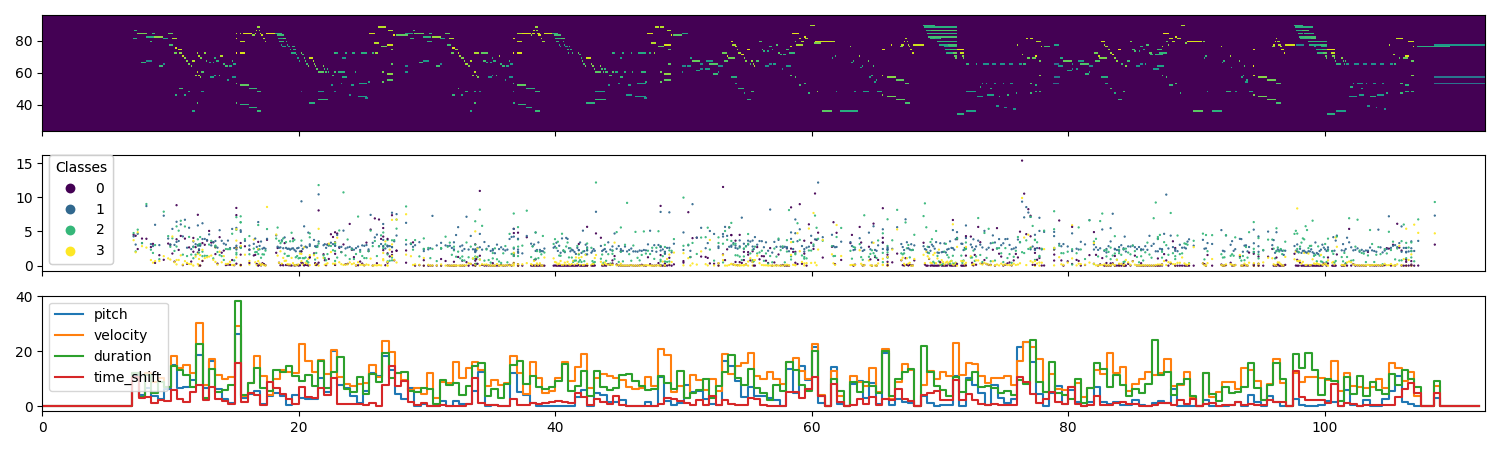

In [12]:
f = f'/home/mathias/.cache/mutdata/pia/databases/Piano/transcriptions/midi/{piece}.mid'
midi2 = pretty_midi.PrettyMIDI(f)
sr = 10
pr2 = midi2.get_piano_roll(sr).T
end = pr2.shape[0]/sr


legends = dataloader_generator.features
with torch.no_grad():
    unique_timepoints, cum_ics = decoder_handler.compute_token_onsets(
        x=x.clone(),
        metadata_dict=metadata_dict,
        match_original_onsets=np.sort([n.start for n in midi2.instruments[0].notes])[None]
    )
integrator = functools.partial(decoder_handler.integration, unique_timepoint=unique_timepoints, cum_ics=cum_ics)
fig, ax = plt.subplots(3, 1, figsize=(15,4.5), sharex=True)
nr = (24,96)
ax[0].imshow(pr2.T[slice(*nr)], origin='lower',extent=[0, end, *nr],aspect='auto', interpolation='none')
xs, ics = DecoderEventsHandler.quant(xs=0.5, end=end, interpolator=integrator)
start=pr2.any(1).argmax()/sr

channels = slice(0, 4)
n_channels = channels.stop- channels.start
n_points = len(unique_timepoints)
# ax[1].plot(unique_timepoint, cum_ics[:, channel],'.-')
c = np.broadcast_to(np.arange(n_channels)[None,:], (n_points, n_channels)).flatten()

times = np.broadcast_to(np.array(unique_timepoints)[:,None], (n_points, n_channels)).flatten()
scatter = ax[1].scatter(
    times,
    cum_ics[:, channels].numpy().flatten(),
    c=c,
    s=1.5,
    marker='.'
)
legend1 = ax[1].legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax[1].add_artist(legend1)

# produce a legend with a cross-section of sizes from the scatter
# handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
# legend2 = ax[1].legend(handles, labels, loc="upper right", title="Sizes")


ax[2].step(xs[:-1], ics[:, channels], where='post')
ax[2].legend(legends[channels])

fig.tight_layout()


# fig.show()

In [13]:
plt.savefig('ic_curve.pdf')

In [22]:
linear = [functools.partial(np.interp, xp=unique_timepoints, fp=cum_ic, left=None, right=None, period=None)
                              for cum_ic in cum_ics[0]]

In [31]:
pr2.any(axis=0).argmax()

34

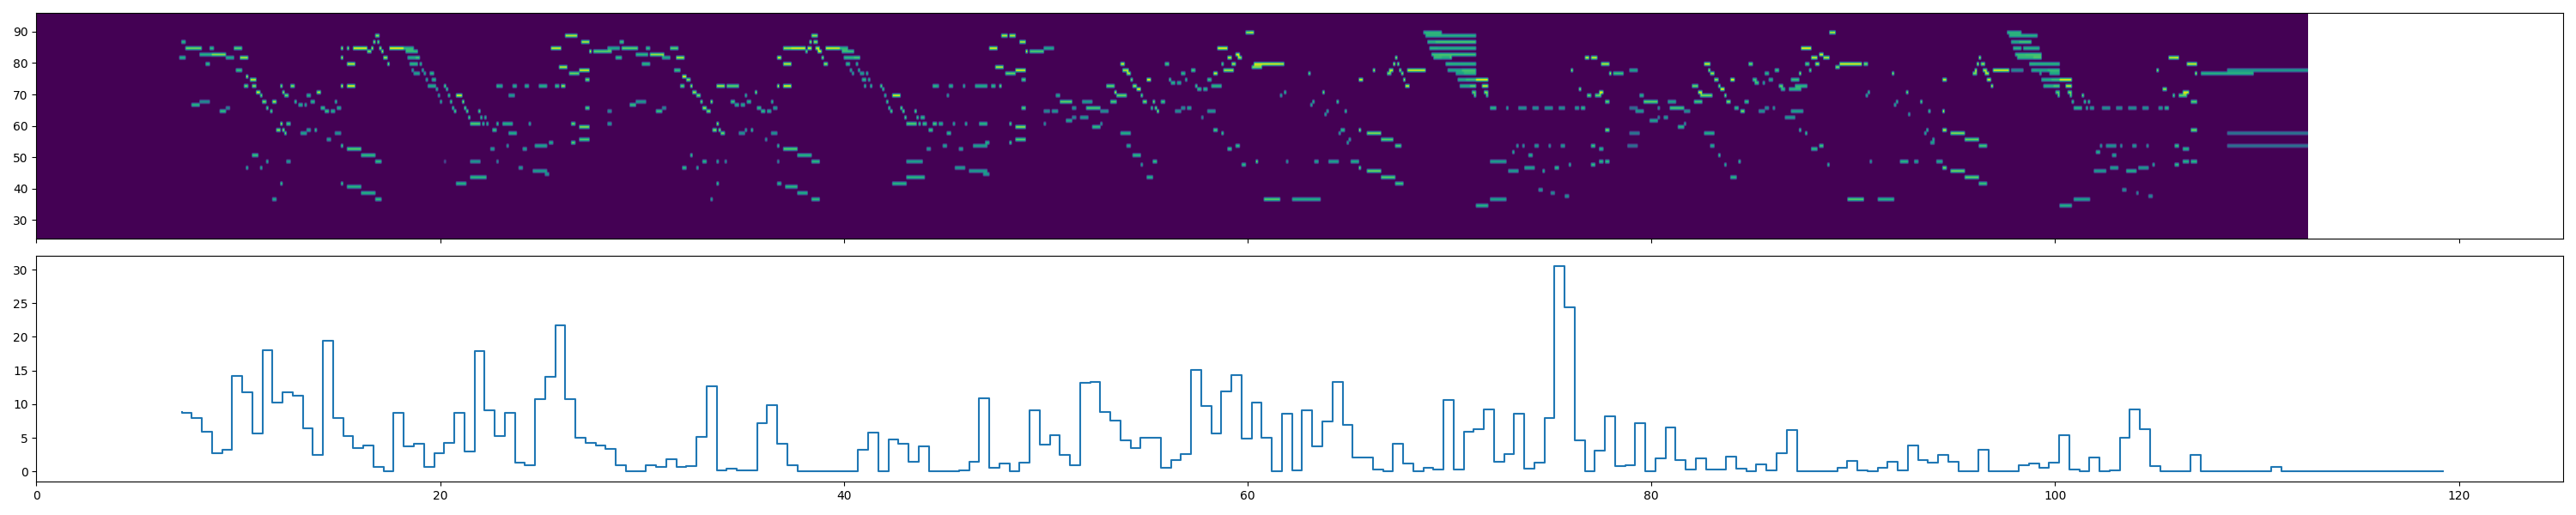

(<Figure size 1920x1440 with 1 Axes>, <AxesSubplot:>)

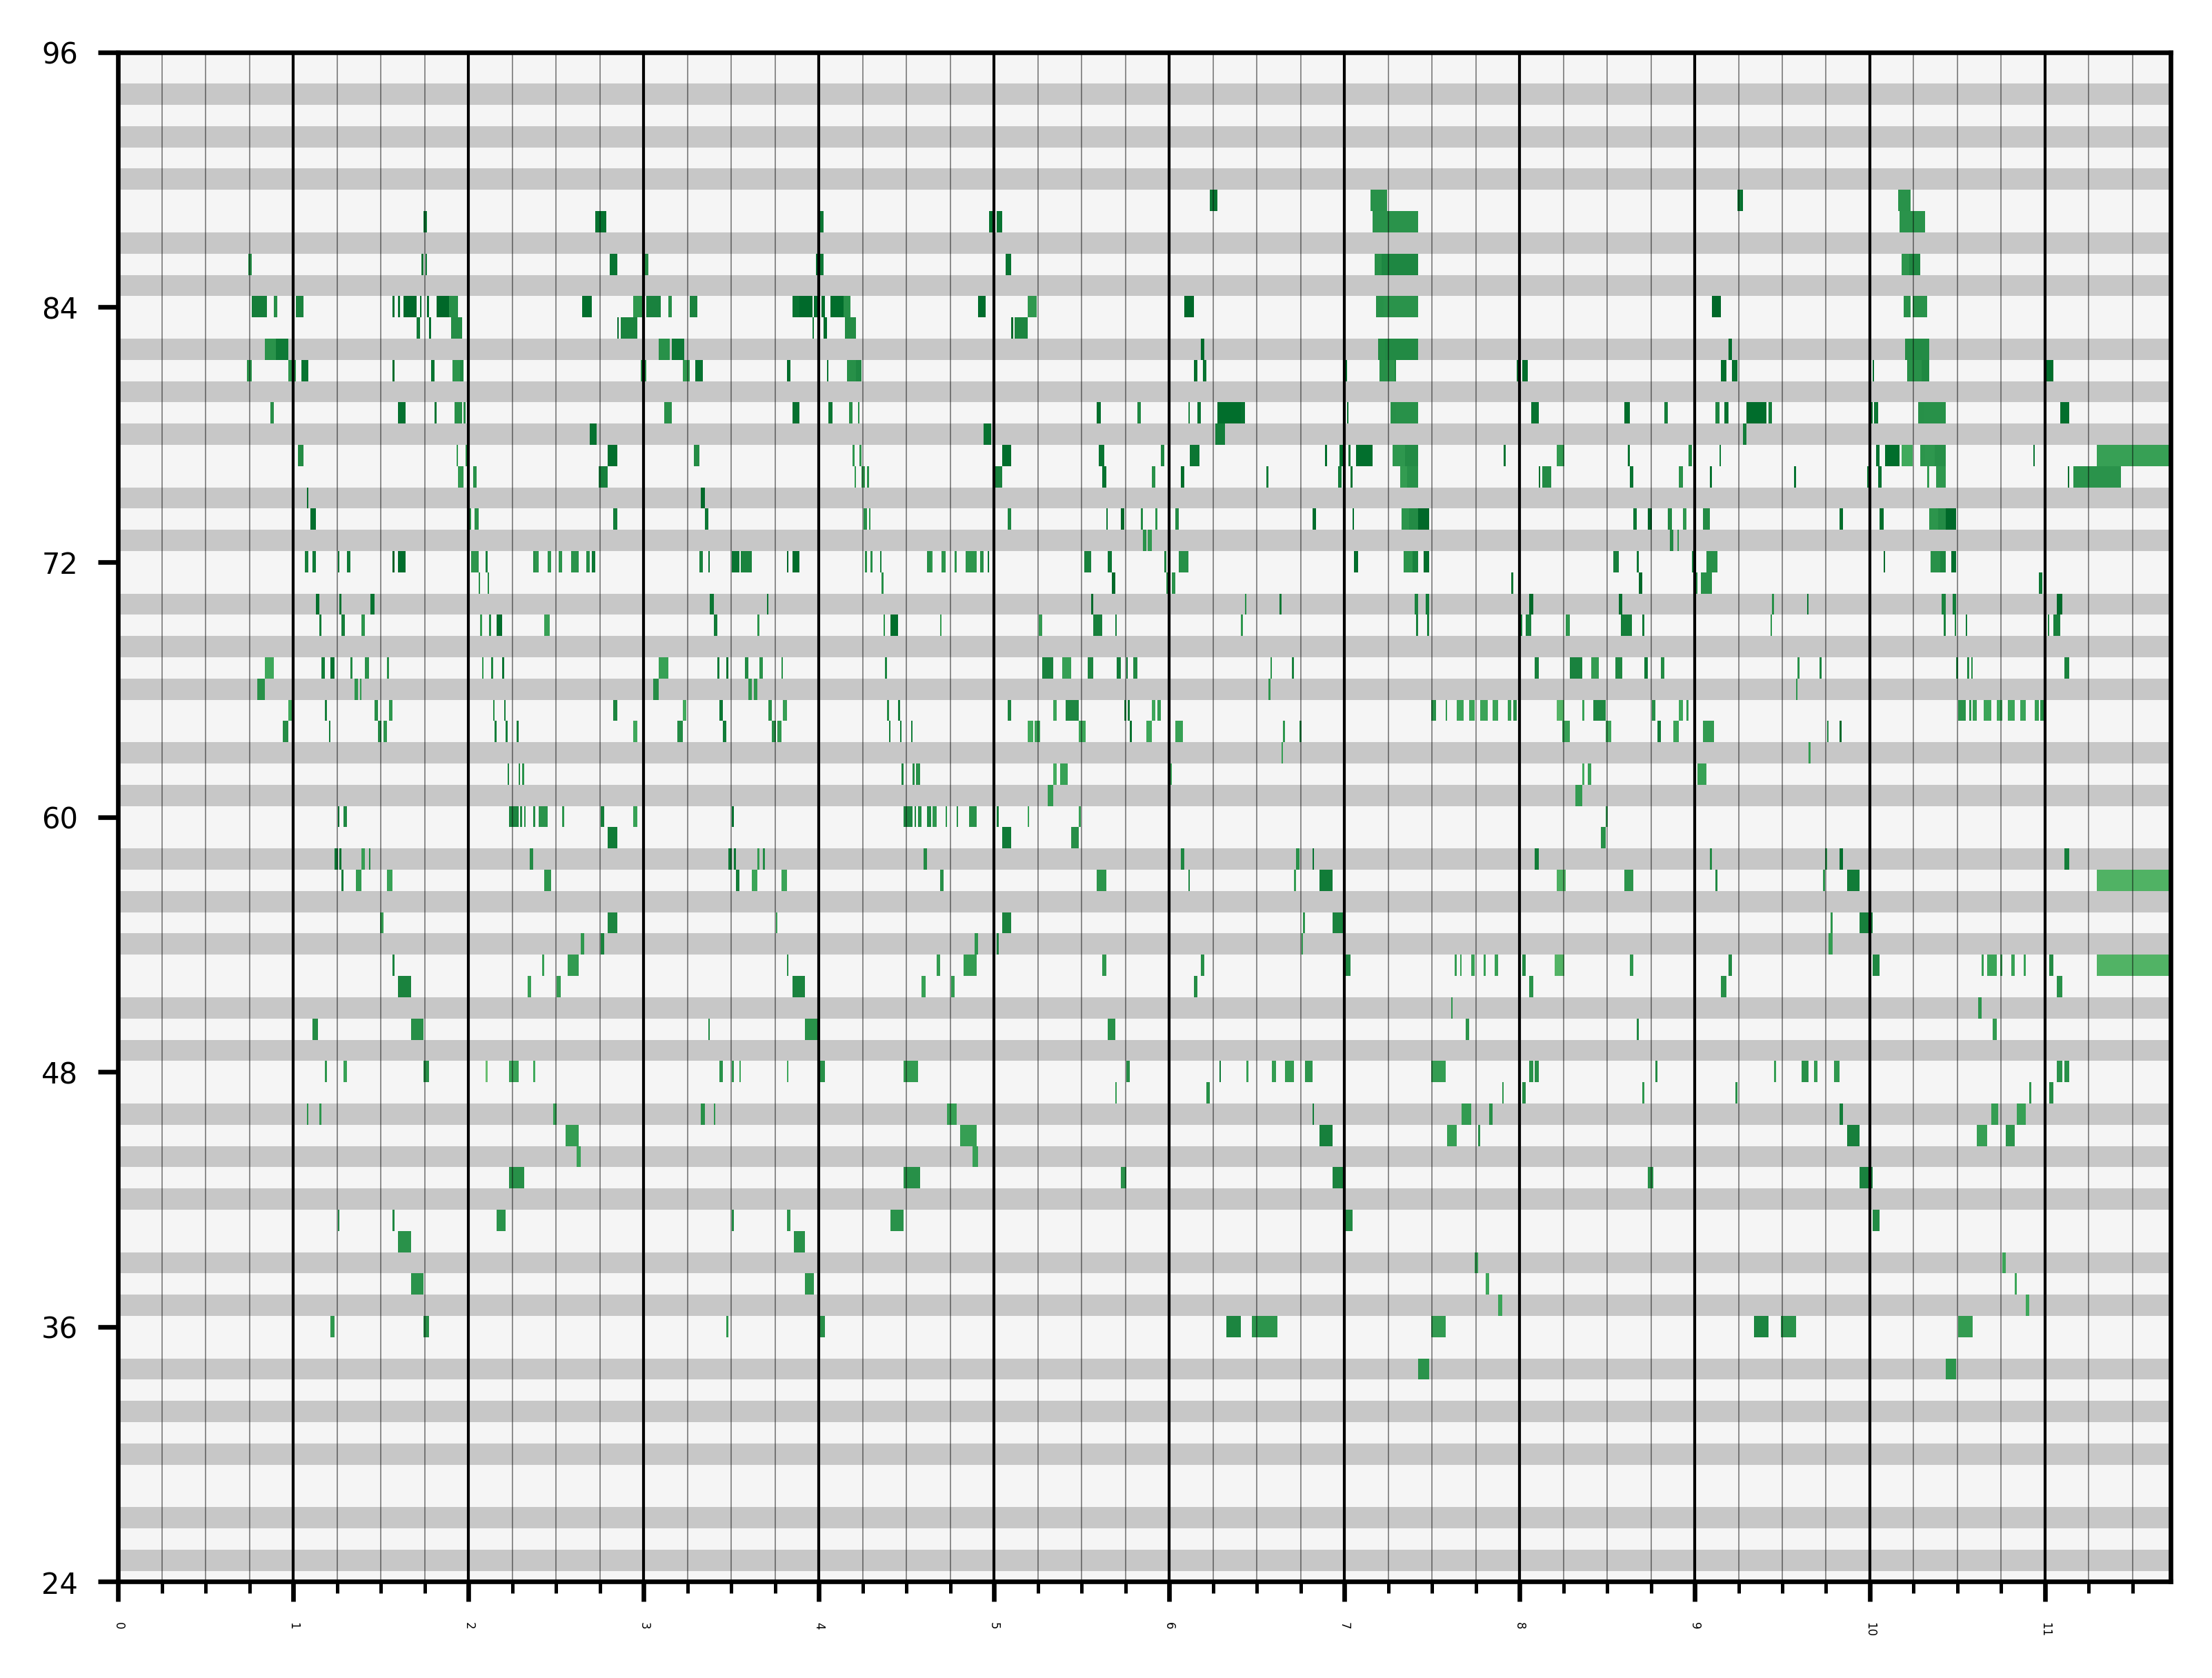

In [39]:
nr = (24,96)
miditoolkit.vis.plot(pr2[:, slice(*nr)], note_range=nr)